In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

### Read Data

In [3]:
data_path = 'RfqAssignmentData.xlsx'
train = pd.read_excel(data_path,sheet_name="RfqTrainingData",index_col="Time")
test = pd.read_excel(data_path,sheet_name="OutOfSampleData",index_col="Time")
competition = pd.read_excel(data_path,sheet_name="CompetitionData",index_col="Time")

### Clean and Prepare the Data
Split = 0 (use entire dataset on model)  
Split = 1 (split between bid and offer sides; 2 total datasets)  
Split = 2 (split between bid and offer sides for each bond; 6 total datasets)

In [4]:
def clean(df,features,split=0,part=1,show_PL = False):
    df = df.copy()
    df.Counterparty = pd.to_numeric(df.Counterparty.str.extract('(\d+)')[0])
    df.Traded = df.Traded.map({"MISSED":0,"DONE":1})
    df.Side = df.Side.map({"Offer":1,"Bid":-1})
    df["Diff"] = (df.QuotedPrice/df.MidPrice-1)*df.Side
    df["CP0"] = 0+(df["Counterparty"]==0)
    df["CP1"] = 0+(df["Counterparty"]==1)
    df["CP2"] = 0+(df["Counterparty"]==2)
    df["CP3"] = 0+(df["Counterparty"]==3)
    df.Bond = pd.to_numeric(df.Bond.str.extract('(\d+)')[0])
    df["Bond0"] = 0+(df["Bond"]==0)
    df["Bond1"] = 0+(df["Bond"]==1)
    df["Bond2"] = 0+(df["Bond"]==2)
    
    if part == 2:
      if show_PL == True:
        df["Return"] = np.sign(df.NextMidPrice-df.QuotedPrice)
        df["Success"] = df["Traded"] * df.Return.map({-1:1,1:2,0:2})  
        
        return df[features+["Traded","Return","Success"]+["PL"]]
      else:
        df["Return"] = np.sign(df.NextMidPrice-df.QuotedPrice)
        df["Success"] = df["Traded"] * df.Return.map({-1:1,1:2,0:2})  
        
        return df[features+["Traded","Return","Success"]]
    
    if split==2:
        offer = []
        bid = []
        for i in range(2):
            temp = df[df.Bond==i].copy()
            temp = temp[["Side","Notional","Counterparty","Diff","Competitors","Traded"]]
            offer.append(temp[temp.Side==1].drop(columns=["Side"]).copy())
            bid.append(temp[temp.Side==-1].drop(columns=["Side"]).copy())
        return bid, offer
    elif split==1:
        temp = df[df.Bond==i].copy()
        temp = temp[["Side","Notional","Counterparty","Diff","Competitors","Traded"]]
        offer = temp[temp.Side==1].drop(columns=["Side"]).copy()
        bid = temp[temp.Side==-1].drop(columns=["Side"]).copy()
        return bid, offer
    else:
        return df[features+["Traded"]]

In [5]:
features = ["Bond0","Bond1","Bond2","Side","Diff","Notional","Competitors","CP0","CP1","CP2","CP3"]
df = clean(train,features)
normalize_ratio = df[features].max()
# Run the line below if we want to normalize the features
# Otherwise, comment out the line so that the features are kept original
df[features] = df[features]/normalize_ratio
df.describe()

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.497800,0.101000,0.40120,0.029200,0.040942,0.15781,0.624150,0.204200,0.300800,0.049400,0.445600,0.518200
std,0.500045,0.301359,0.49019,0.999674,0.047085,0.35411,0.279401,0.403156,0.458652,0.216723,0.497082,0.499719
min,0.000000,0.000000,0.00000,-1.000000,0.000000,0.00010,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,-1.000000,0.012122,0.00010,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,1.000000,0.027955,0.00010,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.00000,1.000000,0.052287,0.00200,0.750000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_test = clean(test,features)
# Run the line below if we want to normalize the features
# Otherwise, comment out the line so that the features are kept original
df_test[features] = df_test[features]/normalize_ratio
df_test.head()

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded
Time,,,,,,,,,,,,
30000,1.0,0.0,0.0,-1.0,0.016701,0.0001,0.25,0.0,1.0,0.0,0.0,0
30001,1.0,0.0,0.0,1.0,0.011139,0.0001,0.25,0.0,0.0,0.0,1.0,1
30002,0.0,0.0,1.0,-1.0,0.009415,0.0170,0.50,0.0,1.0,0.0,0.0,1
30003,0.0,0.0,1.0,-1.0,0.009418,0.0001,1.00,0.0,0.0,0.0,1.0,1
30004,0.0,0.0,1.0,1.0,0.047066,1.0000,0.75,0.0,1.0,0.0,0.0,0


### Put Training and Test Data into Array Format for Scikit Learn

In [7]:
X_train = df[features].values
y_train = np.ravel(df["Traded"].values)

X_test = df_test[features].values
y_test = np.ravel(df_test["Traded"].values)

### Create Neural Network Model with Scikit Learn

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(11,11,11), activation='logistic', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

### Training Results

In [8]:
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[2105  304]
 [ 238 2353]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2409
           1       0.89      0.91      0.90      2591

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



### Test Results

In [9]:
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[340 113]
 [ 27 520]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       453
           1       0.82      0.95      0.88       547

    accuracy                           0.86      1000
   macro avg       0.87      0.85      0.86      1000
weighted avg       0.87      0.86      0.86      1000



In [10]:
df["ProbabilityTraded"] = mlp.predict_proba(X_train)[:,1]
df_test["ProbabilityTraded"] = mlp.predict_proba(X_test)[:,1]
df_test.head(15)

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded,ProbabilityTraded
Time,,,,,,,,,,,,,
30000,1.0,0.0,0.0,-1.0,0.016701,0.0001,0.25,0.0,1.0,0.0,0.0,0,0.563077
30001,1.0,0.0,0.0,1.0,0.011139,0.0001,0.25,0.0,0.0,0.0,1.0,1,0.875223
30002,0.0,0.0,1.0,-1.0,0.009415,0.0170,0.50,0.0,1.0,0.0,0.0,1,0.971252
30003,0.0,0.0,1.0,-1.0,0.009418,0.0001,1.00,0.0,0.0,0.0,1.0,1,0.998161
30004,0.0,0.0,1.0,1.0,0.047066,1.0000,0.75,0.0,1.0,0.0,0.0,0,0.176060
30005,0.0,0.0,1.0,-1.0,0.014144,0.0001,1.00,0.0,0.0,0.0,1.0,1,0.996380
30006,1.0,0.0,0.0,1.0,0.027847,0.0050,1.00,0.0,1.0,0.0,0.0,0,0.838343
30007,0.0,0.0,1.0,-1.0,0.018803,0.0001,0.25,1.0,0.0,0.0,0.0,0,0.391418
30008,1.0,0.0,0.0,1.0,0.000000,0.0010,0.25,0.0,0.0,1.0,0.0,1,0.165824


# Problem 2


In [11]:
df = clean(train,features,part=2)
df[features] = df[features]/normalize_ratio
df_test = clean(test,features,part=2)
df_test[features] = df_test[features]/normalize_ratio

In [12]:
X_train = df[features].values
y_train = np.ravel(df["Success"].values)

X_test = df_test[features].values
y_test = np.ravel(df_test["Success"].values)

In [13]:
mlp2 = MLPClassifier(hidden_layer_sizes=(500,500,11), activation='tanh', solver='adam', max_iter=500)
mlp2.fit(X_train,y_train)

predict_train = mlp2.predict(X_train)
predict_test = mlp2.predict(X_test)
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[2269   79   61]
 [ 198  602  474]
 [ 207  347  763]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2409
           1       0.59      0.47      0.52      1274
           2       0.59      0.58      0.58      1317

    accuracy                           0.73      5000
   macro avg       0.67      0.66      0.67      5000
weighted avg       0.71      0.73      0.72      5000



In [14]:
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[389  36  28]
 [ 24 106 122]
 [ 23  98 174]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       453
           1       0.44      0.42      0.43       252
           2       0.54      0.59      0.56       295

    accuracy                           0.67      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.67      0.67      0.67      1000



## Approach 1

In [15]:
df_test['Success01'] = df_test.Success.map({0:0,1:0,2:1})
df["ProbabilitySuccess"] = mlp2.predict_proba(X_train)[:,2]
df_test["PredictedSuccess"] = mlp2.predict(X_test)
df_test["ProbabilitySuccess"] = mlp2.predict_proba(X_test)[:,2]
df_test["PredictedSuccess01"] = df_test.PredictedSuccess.map({0:0,1:0,2:1})
# Show only RFQs with PredictedSuccess01 = 1 and Success01 = 0, or PredictedSuccess01 = 
# 0 and Success01 = 1 (misclassified RFQs only)
df_test_filter = df_test.loc[(df_test['Success01'] + df_test['PredictedSuccess01'] == 1)]
df_test_filter = df_test_filter.drop('Success', 1)
df_test_filter = df_test_filter.drop('PredictedSuccess', 1)
#df_test_filter = df_test_filter.sort_values('ProbabilitySuccess',ascending=False)
df_test_filter.head(50)

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded,Return,Success01,ProbabilitySuccess,PredictedSuccess01
Time,,,,,,,,,,,,,,,,
30001,1.0,0.0,0.0,1.0,0.011139,0.0001,0.25,0.0,0.0,0.0,1.0,1,1.0,1,0.412943,0
30011,0.0,0.0,1.0,-1.0,0.004696,0.0001,0.25,1.0,0.0,0.0,0.0,1,-1.0,0,0.577760,1
30012,0.0,0.0,1.0,-1.0,0.004699,0.0001,0.25,1.0,0.0,0.0,0.0,1,-1.0,0,0.577737,1
30014,0.0,0.0,1.0,-1.0,0.023547,0.0010,0.50,0.0,0.0,0.0,1.0,0,1.0,0,0.507550,1
30023,1.0,0.0,0.0,-1.0,0.022177,0.0001,0.75,0.0,1.0,0.0,0.0,0,-1.0,0,0.534980,1
30027,0.0,0.0,1.0,1.0,0.009346,0.0001,0.75,0.0,0.0,0.0,1.0,1,0.0,1,0.493635,0
30028,1.0,0.0,0.0,-1.0,-0.000000,0.0001,0.50,0.0,0.0,0.0,1.0,1,1.0,1,0.391645,0
30029,0.0,1.0,0.0,1.0,0.027801,0.0001,0.75,0.0,1.0,0.0,0.0,1,1.0,1,0.467916,0
30033,0.0,0.0,1.0,-1.0,0.014014,0.0010,1.00,0.0,1.0,0.0,0.0,1,-1.0,0,0.543639,1


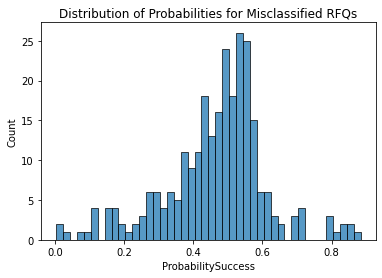

In [16]:
# Find the highest probability of predicting success01 = 1 which gives the
# misclassified labels
df_test_filter['ProbabilitySuccess'].max()

# Visualize distribution of probabilities giving misclassified labels
sns.histplot(df_test_filter['ProbabilitySuccess'], binwidth = 0.02).set_title("Distribution of Probabilities for Misclassified RFQs")
plt.show()
#sns.histplot(df_test['ProbabilitySuccess'], binwidth = 0.02)

From the histogram above, we see that the number of misclassified RFQs is insignificant for probability values greater than 0.6 (approximately).

So now, we will try to only make a trade if the probability of success is greater than 0.6. Specifically, we will vary the diff (scaled distance from mid) to find the highest diff which meets our probability of success criterion above. Then, we can use this diff value to solve for the quoted price. This will give us some guarantee that the quoted price will translate to a "successful" trade, meaning positive PnL and a done trade.

In [17]:
# Count number of observations with RFQs correctly labeled as '1'
df_correct = df_test.loc[(df_test['Success01'] + df_test['PredictedSuccess01'] == 2)]
print('The number of correctly labeled observations is:', df_correct.shape[0])

# Count number of observations with 'ProbabilitySuccess' > 0.6 for 
# the RFQs correctly labeled as '1'
df_correct_filter = df_correct.loc[(df_correct['ProbabilitySuccess'] > 0.6)]
print('The number of filtered correctly labeled observations is:', df_correct_filter.shape[0])

The number of correctly labeled observations is: 174
The number of filtered correctly labeled observations is: 79


This seems like a reasonable condition to impose since we would still be able to make about 40% (80/198) of all trades which have been identified as good trades by our Multi-layer Perceptron classifier. Theoretically, this should give us a good balance between trading frequency and overall trading PnL.

In [18]:
# All RFQ orders that transacted and have a positive PnL, regardless of predicted label
df_success = df_test.loc[(df_test['Success01'] == 1)]
df_success = df_success.sort_values('ProbabilitySuccess',ascending=True)
df_success

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded,Return,Success,Success01,PredictedSuccess,ProbabilitySuccess,PredictedSuccess01
Time,,,,,,,,,,,,,,,,,,
30981,0.0,0.0,1.0,1.0,0.060936,0.0140,0.75,1.0,0.0,0.0,0.0,1,1.0,2,1,0,0.003644,0
30142,0.0,0.0,1.0,1.0,0.032196,0.0020,0.50,1.0,0.0,0.0,0.0,1,1.0,2,1,0,0.016224,0
30384,0.0,0.0,1.0,-1.0,0.059819,0.2360,0.75,0.0,0.0,0.0,1.0,1,1.0,2,1,0,0.031197,0
30326,0.0,1.0,0.0,-1.0,0.068913,0.0001,0.25,0.0,1.0,0.0,0.0,1,1.0,2,1,0,0.064306,0
30374,1.0,0.0,0.0,-1.0,0.022090,0.0001,0.25,1.0,0.0,0.0,0.0,1,1.0,2,1,0,0.100760,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30160,1.0,0.0,0.0,1.0,0.005533,0.0001,1.00,0.0,1.0,0.0,0.0,1,1.0,2,1,2,0.874373,1
30589,0.0,0.0,1.0,1.0,0.000000,0.0001,0.75,0.0,1.0,0.0,0.0,1,1.0,2,1,2,0.887574,1
30530,0.0,0.0,1.0,1.0,0.000000,0.0001,0.75,0.0,1.0,0.0,0.0,1,1.0,2,1,2,0.887574,1


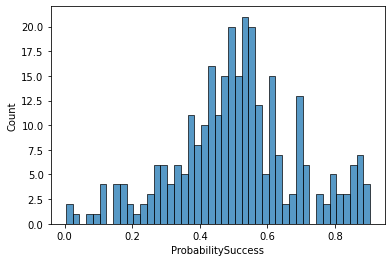

In [19]:
# Visualize distribution of probabilities for all 'successful' RFQs
sns.histplot(df_success['ProbabilitySuccess'], binwidth = 0.02)

In [20]:
# Count number of observations for RFQs labeled as '1' (successful RFQs)
print('The number of successful RFQs is:', df_success.shape[0])

# Count number of observations with 'ProbabilitySuccess' > 0.6 for 
# the RFQs labeled as '1'
df_success_filter = df_success.loc[(df_success['ProbabilitySuccess'] > 0.6)]
print('The number of filtered successful RFQs is:', df_success_filter.shape[0])

The number of successful RFQs is: 295
The number of filtered successful RFQs is: 79


The above analysis and comparison between the number of successful RFQs and the number of successful RFQs which meet our probability of success requirement show that, in fact, only about 27.1% (80/295) of all successful RFQs are detected by our Multi-layer Perceptron classifier with the imposed condition.

## Approach 2

In [21]:
df_testwpl = clean(test,features,part=2,show_PL=True)
df_testwpl[features] = df_testwpl[features]/normalize_ratio
df_testwpl = df_testwpl['PL']
#type(df_testwpl)

df_test['PL'] = df_testwpl
df_test

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded,Return,Success,Success01,PredictedSuccess,ProbabilitySuccess,PredictedSuccess01,PL
Time,,,,,,,,,,,,,,,,,,,
30000,1.0,0.0,0.0,-1.0,0.016701,0.0001,0.25,0.0,1.0,0.0,0.0,0,-1.0,0,0,0,0.153873,0,0.0
30001,1.0,0.0,0.0,1.0,0.011139,0.0001,0.25,0.0,0.0,0.0,1.0,1,1.0,2,1,1,0.412943,0,-0.2
30002,0.0,0.0,1.0,-1.0,0.009415,0.0170,0.50,0.0,1.0,0.0,0.0,1,-1.0,1,0,1,0.456329,0,-34.0
30003,0.0,0.0,1.0,-1.0,0.009418,0.0001,1.00,0.0,0.0,0.0,1.0,1,1.0,2,1,2,0.547623,1,0.9
30004,0.0,0.0,1.0,1.0,0.047066,1.0000,0.75,0.0,1.0,0.0,0.0,0,-1.0,0,0,0,0.059905,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30995,1.0,0.0,0.0,1.0,0.109626,0.0010,0.75,0.0,1.0,0.0,0.0,0,-1.0,0,0,0,0.007060,0,0.0
30996,1.0,0.0,0.0,-1.0,0.011526,0.0001,0.25,0.0,1.0,0.0,0.0,1,1.0,2,1,0,0.255275,0,0.6
30997,0.0,0.0,1.0,1.0,0.023404,0.2430,0.75,0.0,0.0,0.0,1.0,1,1.0,2,1,1,0.385646,0,-486.0


In [22]:
# Compute the optimal probability of success value which maximizes PL
probs = df_test['ProbabilitySuccess'].tolist()
best_p = 0
max_pnl = 0
p_arr = []
pnl_arr = []
for p in probs:
  #print('Probability:', p)
  p_arr.append(p)
  df_temp = df_test.loc[(df_test['ProbabilitySuccess'] >= p)]
  pnl = df_temp['PL'].sum()
  #print('PnL:', pnl)
  pnl_arr.append(pnl)
  if pnl > max_pnl:
    max_pnl = pnl
    best_p = p

print('Best probability is:', best_p)
print('Max PnL is:', max_pnl)

Best probability is: 0.3081048601097478
Max PnL is: 86030.00000000796


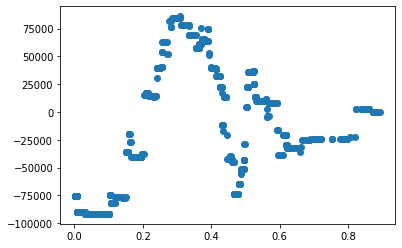

In [23]:
plt.scatter(p_arr,pnl_arr)

Approach 1 gives us a probability of success threshold of 0.6.

Approach 2 gives us a probability of success threshold of 0.350603.

In [24]:
prob_threshold = (best_p + 0.6)/2
print('The average probability threshold is:', round(prob_threshold,4))

The average probability threshold is: 0.4541


## Competition

In [25]:
df_comp = clean(competition,features)
df_comp[features] = df_comp[features]/normalize_ratio
df_comp

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3,Traded
Time,,,,,,,,,,,,
31003,0.0,0.0,1.0,-1.0,0.023412,1.000,0.50,0.0,1.0,0.0,0.0,NaN
31004,0.0,1.0,0.0,-1.0,0.010660,0.086,0.25,0.0,0.0,1.0,0.0,NaN
31008,1.0,0.0,0.0,1.0,0.895968,0.564,1.00,0.0,0.0,0.0,1.0,NaN


In [26]:
# Iterate over values of diff to get the largest diff
# that gives us a probability of success > 0.3506
def getDiff(X,start_diff):
  for val in np.arange(start_diff,0,-0.005):
    print('Value being tested:', val)
    X.iloc[0].Diff = val
    prob = mlp2.predict_proba(X)[0][2]
    if prob >= 0.3506:
      return val
  print('No diff value can satisfy requirement. Give a bad quote so that the RFQ does not transact.')

$$ Diff = \mid\frac{QuotedPrice - MidPrice}{MidPrice}\mid$$

In [27]:
# Compute the quoted price based on the given diff value
def getPrice(time_index,diff):
  df_comp['MidPrice'] = competition['MidPrice']
  df_temp1 = df_comp[df_comp.index == time_index]
  #print(df_temp1)
  mid_p = df_temp1['MidPrice'].iloc[0]
  #print(mid_p)
  side = df_temp1['Side'].iloc[0]
  #print(side)
  quoted_price = (diff*normalize_ratio[4]/side)*mid_p + mid_p
  
  return quoted_price

First competition RFQ

In [28]:
X1 = df_comp[features][df_comp.index==31003].copy()
X1.iloc[0].Diff = 0.02634
X1

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3
Time,,,,,,,,,,,
31003,0.0,0.0,1.0,-1.0,0.02634,1.0,0.5,0.0,1.0,0.0,0.0


In [29]:
mlp2.predict_proba(X1)[0][2]

0.2318803336461257

In [30]:
getDiff(X1,start_diff=0.9)

Value being tested: 0.9
Value being tested: 0.895
Value being tested: 0.89
Value being tested: 0.885
Value being tested: 0.88
Value being tested: 0.875
Value being tested: 0.87
Value being tested: 0.865
Value being tested: 0.86
Value being tested: 0.855
Value being tested: 0.85
Value being tested: 0.845
Value being tested: 0.84
Value being tested: 0.835
Value being tested: 0.83
Value being tested: 0.825
Value being tested: 0.82
Value being tested: 0.815
Value being tested: 0.8099999999999999
Value being tested: 0.8049999999999999
Value being tested: 0.7999999999999999
Value being tested: 0.7949999999999999
Value being tested: 0.7899999999999999
Value being tested: 0.7849999999999999
Value being tested: 0.7799999999999999
Value being tested: 0.7749999999999999
Value being tested: 0.7699999999999999
Value being tested: 0.7649999999999999
Value being tested: 0.7599999999999999
Value being tested: 0.7549999999999999
Value being tested: 0.7499999999999999
Value being tested: 0.7449999999999

0.01999999999999924

In [31]:
price1 = getPrice(time_index=31003,diff=0.022339999999999995)
print('Our quoted price for Bond 2 is:', price1)

Our quoted price for Bond 2 is: 134.50229037019747


Second competition RFQ

In [32]:
X2 = df_comp[features][df_comp.index==31004].copy()
X2.iloc[0].Diff = 0.05034
X2

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3
Time,,,,,,,,,,,
31004,0.0,1.0,0.0,-1.0,0.05034,0.086,0.25,0.0,0.0,1.0,0.0


In [33]:
mlp2.predict_proba(X2)[0][2]

0.06277628963457763

In [34]:
getDiff(X2,start_diff=0.9)

Value being tested: 0.9
Value being tested: 0.895
Value being tested: 0.89
Value being tested: 0.885
Value being tested: 0.88
Value being tested: 0.875
Value being tested: 0.87
Value being tested: 0.865
Value being tested: 0.86
Value being tested: 0.855
Value being tested: 0.85
Value being tested: 0.845
Value being tested: 0.84
Value being tested: 0.835
Value being tested: 0.83
Value being tested: 0.825
Value being tested: 0.82
Value being tested: 0.815
Value being tested: 0.8099999999999999
Value being tested: 0.8049999999999999
Value being tested: 0.7999999999999999
Value being tested: 0.7949999999999999
Value being tested: 0.7899999999999999
Value being tested: 0.7849999999999999
Value being tested: 0.7799999999999999
Value being tested: 0.7749999999999999
Value being tested: 0.7699999999999999
Value being tested: 0.7649999999999999
Value being tested: 0.7599999999999999
Value being tested: 0.7549999999999999
Value being tested: 0.7499999999999999
Value being tested: 0.7449999999999

In [35]:
price2 = getPrice(time_index=31004,diff=0.01034)
print('Our quoted price for Bond 1 is:', price2)

Our quoted price for Bond 1 is: 118.18060109612063


Third competition RFQ

In [36]:
X3 = df_comp[features][df_comp.index==31008].copy()
X3.iloc[0].Diff = 0.02869
X3

,Bond0,Bond1,Bond2,Side,Diff,Notional,Competitors,CP0,CP1,CP2,CP3
Time,,,,,,,,,,,
31008,1.0,0.0,0.0,1.0,0.02869,0.564,1.0,0.0,0.0,0.0,1.0


In [37]:
mlp2.predict_proba(X3)[0][2]

0.28703881174222645

In [38]:
getDiff(X3,start_diff=0.9)

Value being tested: 0.9
Value being tested: 0.895
Value being tested: 0.89
Value being tested: 0.885
Value being tested: 0.88
Value being tested: 0.875
Value being tested: 0.87
Value being tested: 0.865
Value being tested: 0.86
Value being tested: 0.855
Value being tested: 0.85
Value being tested: 0.845
Value being tested: 0.84
Value being tested: 0.835
Value being tested: 0.83
Value being tested: 0.825
Value being tested: 0.82
Value being tested: 0.815
Value being tested: 0.8099999999999999
Value being tested: 0.8049999999999999
Value being tested: 0.7999999999999999
Value being tested: 0.7949999999999999
Value being tested: 0.7899999999999999
Value being tested: 0.7849999999999999
Value being tested: 0.7799999999999999
Value being tested: 0.7749999999999999
Value being tested: 0.7699999999999999
Value being tested: 0.7649999999999999
Value being tested: 0.7599999999999999
Value being tested: 0.7549999999999999
Value being tested: 0.7499999999999999
Value being tested: 0.7449999999999

0.01999999999999924

In [39]:
price3 = getPrice(time_index=31008,diff=0.01999999999999924)
print('Our quoted price for Bond 0 is:', price3)

Our quoted price for Bond 0 is: 109.37971107791519


#Plots 

In [40]:
df_comp = clean(competition,features,part=2)

distances = np.arange(0,0.002,0.00001) # percent difference

nontrade=np.zeros([len(distances),len(df_comp)])
profit = np.zeros([len(distances),len(df_comp)])
loss = np.zeros([len(distances),len(df_comp)])
for i,dist in enumerate(distances):
    temp = df_comp.copy()
    temp.Diff = dist
    temp[features] = temp[features]/normalize_ratio
    X = temp[features].values
    nontrade[i,:] = mlp2.predict_proba(X)[:,0]
    profit[i,:] = mlp2.predict_proba(X)[:,2]
    loss[i,:] = mlp2.predict_proba(X)[:,1]

profit = pd.DataFrame(profit,index=distances,columns=["Bond 2","Bond 1","Bond 0"])
loss = pd.DataFrame(loss,index=distances,columns=["Bond 2","Bond 1","Bond 0"])
nontrade = pd.DataFrame(nontrade,index=distances,columns=["Bond 2","Bond 1","Bond 0"])

Text(0.5, 0, 'Percent Difference of Quote and Mid Prices')

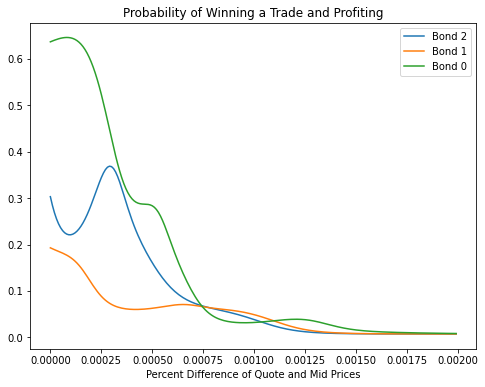

In [41]:
profit.plot(figsize=(8,6),title="Probability of Winning a Trade and Profiting")
plt.xlabel('Percent Difference of Quote and Mid Prices')

In [42]:
profit[profit["Bond 2"] == profit["Bond 2"].max()]

,Bond 2,Bond 1,Bond 0
0.00029,0.368688,0.073549,0.447872


Text(0.5, 0, 'Percent Difference of Quote and Mid Prices')

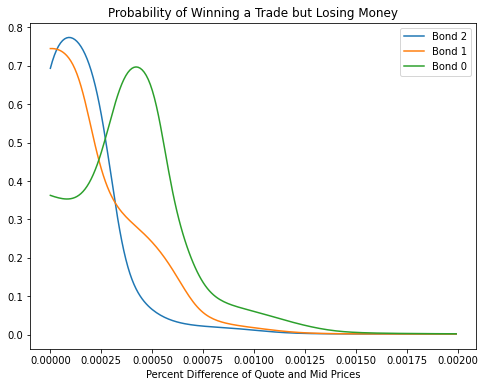

In [43]:
loss.plot(figsize=(8,6),title="Probability of Winning a Trade but Losing Money")
plt.xlabel('Percent Difference of Quote and Mid Prices')

In [44]:
loss[loss["Bond 0"] == loss["Bond 0"].max()]

,Bond 2,Bond 1,Bond 0
0.00042,0.119729,0.281837,0.696982


### Plot for our deliverable (Probability of fill as a function of difference from mid price for all 3 RFQs)

In [45]:
df_comp = clean(competition,features)

In [46]:
np.max(train.QuotedPrice/train.MidPrice-1) ## Maximum percent difference between Quote and Mid Price in training data

0.01587227487045406

In [47]:
distances = np.arange(0,0.002,0.00001) # percent difference
probs = np.zeros([len(distances),len(df_comp)])
for i,dist in enumerate(distances):
    temp = df_comp.copy()
    temp.Diff = dist
    temp[features] = temp[features]/normalize_ratio
    X = temp[features].values
    probs[i,:] = mlp.predict_proba(X)[:,1]

probs = pd.DataFrame(probs,index=distances,columns=["Bond 2","Bond 1","Bond 0"])

Text(0, 0.5, 'Probability of Trade Fill')

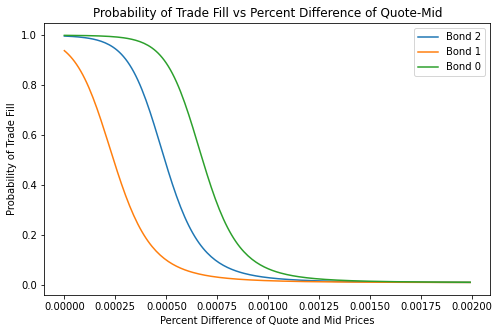

In [48]:
probs.plot(figsize=(8,5),title="Probability of Trade Fill vs Percent Difference of Quote-Mid")
plt.xlabel('Percent Difference of Quote and Mid Prices'); plt.ylabel('Probability of Trade Fill')

### Other plots

In [49]:
df = clean(train,features,part=1)
df[features] = df[features]/normalize_ratio
df_test = clean(test,features,part=1)
df_test[features] = df_test[features]/normalize_ratio

In [50]:
X_train = df[features].values
y_train = np.ravel(df["Traded"].values)

X_test = df_test[features].values
y_test = np.ravel(df_test["Traded"].values)

In [51]:
mlp = MLPClassifier(hidden_layer_sizes=(9,18,9), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[2193  216]
 [ 291 2300]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2409
           1       0.91      0.89      0.90      2591

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [52]:
df_comp = clean(competition,features)
df_comp[features] = df_comp[features]/normalize_ratio
df_comp

X_comp = df_comp[features].copy()

## Probability of fill as a function of distance from mid price for RFQ 1:Bond_2

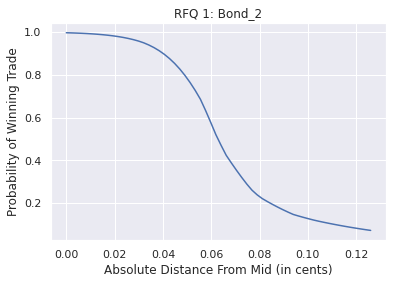

In [53]:
rfq1 = X_comp[X_comp.index==31003].copy()
# rfq1
distances = np.arange(0.00,0.06,0.001)
probs = np.zeros(distances.shape)

for idx,dist in enumerate(distances):
  rfq1.iloc[:,4] = dist
  probs[idx] = mlp.predict_proba(rfq1)[:,1]

# rfq1[features] = rfq1[features] * normalize_ratio
# rfq1['Quoted'] = rfq1['Diff']
# distances = distances * float(rfq1.iloc[:,5])

distances = distances * normalize_ratio['Diff'] * (competition['MidPrice'].iloc[0])
  # quoted_price = (diff*normalize_ratio[4]/side)*mid_p + mid_p
st = sns.axes_style("darkgrid")
sns.set_theme()

plt.plot(distances,probs)
plt.xlabel("Absolute Distance From Mid (in cents)")
plt.ylabel("Probability of Winning Trade")
plt.title("RFQ 1: Bond_2")
plt.show()

# Probability of fill as a function of distance from mid price for RFQ 2: Bond_1

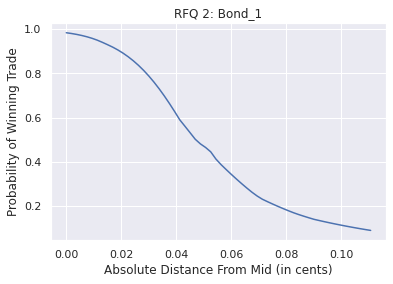

In [54]:
rfq2 = X_comp[X_comp.index==31004].copy()
distances = np.arange(0.00,0.06,0.001)
probs = np.zeros(distances.shape)

for idx,dist in enumerate(distances):
  rfq2.iloc[:,4] = dist
  probs[idx] = mlp.predict_proba(rfq2)[:,1]

distances = distances * normalize_ratio['Diff'] * (competition['MidPrice'].iloc[1])
st = sns.axes_style("darkgrid")
sns.set_theme()

plt.plot(distances,probs)
plt.xlabel("Absolute Distance From Mid (in cents)")
plt.ylabel("Probability of Winning Trade")
plt.title("RFQ 2: Bond_1")
plt.show()

# Probability of fill as a function of distance from mid price for RFQ 3: Bond_0

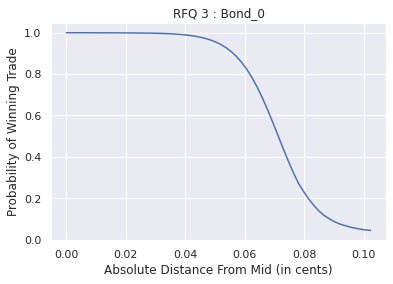

In [55]:
rfq3 = X_comp[X_comp.index==31008].copy()
distances = np.arange(0.00,0.06,0.001)
probs = np.zeros(distances.shape)

for idx,dist in enumerate(distances):
  rfq3.iloc[:,4] = dist
  probs[idx] = mlp.predict_proba(rfq3)[:,1]

distances = distances * normalize_ratio['Diff'] * (competition['MidPrice'].iloc[2])
st = sns.axes_style("darkgrid")
sns.set_theme()

plt.plot(distances,probs)
plt.xlabel("Absolute Distance From Mid (in cents)")
plt.ylabel("Probability of Winning Trade")
plt.title("RFQ 3 : Bond_0")
plt.show()

References:  
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.955&rep=rep1&type=pdf  
https://www.diva-portal.org/smash/get/diva2:1319939/FULLTEXT03.pdf  
https://www.askpython.com/python/examples/naive-bayes-classifier#:~:text=Naive%20Bayes%20Classifier%20with%20Python%20Na%C3%AFve%20Bayes%20Classifier,class%20label%20this%20new%20data%20instance%20belongs%20to.  
https://www.askpython.com/python/examples/naive-bayes-classifier#:~:text=Naive%20Bayes%20Classifier%20with%20Python%20Na%C3%AFve%20Bayes%20Classifier,class%20label%20this%20new%20data%20instance%20belongs%20to.  
https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/  
https://www.codespeedy.com/naive-bayes-algorithm-in-python/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html  
https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

https://www.pluralsight.com/guides/classification-keras  
https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn  
https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/